In [1]:
cd ~/projects/Okapi/tests/transfers/okapi-moose/pin_coupling/

/Users/lindad/projects/Okapi/tests/transfers/okapi-moose/pin_coupling


In [2]:
import openmc

import matplotlib.pyplot as plt
%matplotlib inline

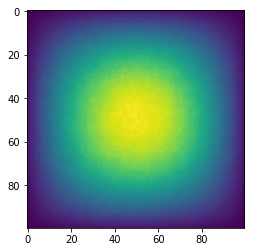

In [3]:
with openmc.StatePoint('statepoint.50.h5') as sp:
    mesh_tally = sp.get_tally(id=2)

    mesh_fission = mesh_tally.get_slice(scores=['kappa-fission'])
    mesh_fission.mean.shape = (100,100)

    plt.imshow(mesh_fission.mean)

    zernike_tally = sp.get_tally(id=1)

In [4]:
from series.Zernike import Zernike

max_order = 10
zernike_list = [Zernike(order, 0, 0, 60) for order in range(max_order + 1)]

In [5]:
zernike_tally.mean.shape = (zernike_tally.mean.size)

for order in range(max_order + 1):
    n = (order + 1) * (order + 2) // 2
    zernike_list[order].coefficients = zernike_tally.mean[:n]

In [6]:
import numpy as np

r = np.linspace(0, 60, 100)
z_evals = [np.zeros((r.size)) for zernike in zernike_list]

for r_index, radius in enumerate(r):
    for z_index, zernike in enumerate(zernike_list):
        z_evals[z_index][r_index] = zernike(radius, 0)

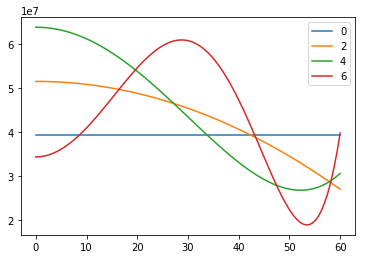

In [7]:
for order, z in enumerate(z_evals):
    if order % 2 == 0 and order <= 6:
        plt.plot(r, z, label=str(order))
plt.legend()